# # Assignment 5 – SeleneX Mini-Prototype: Ovarian Ultrasound + Biomarker Diagnostic Pipeline 

# Data Acquisition and Preparation

In [50]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load class annotations


## MMOTU includes “global-wise category annotations”

In [51]:
train_cls_path = "/kaggle/input/mmotu-ovarian-ultrasound-images-dataset/MMOTU/OTU_2d/train_cls.txt"
val_cls_path = "/kaggle/input/mmotu-ovarian-ultrasound-images-dataset/MMOTU/OTU_2d/val_cls.txt"

df_train = pd.read_csv(train_cls_path, sep=r"\s+", header=None, names=["Image_Name", "Class_ID"])
df_val = pd.read_csv(val_cls_path, sep=r"\s+", header=None, names=["Image_Name", "Class_ID"])

df_cls = pd.concat([df_train, df_val], ignore_index=True)

df_cls = pd.read_csv(train_cls_path, sep=r"\s+", header=None, names=["Image_Name", "Class_ID"])
df_cls["Image_ID"] = df_cls["Image_Name"].str.replace(".JPG", "", case=False)
benign_classes = {0, 1, 2, 3}
df_cls["Label"] = df_cls["Class_ID"].apply(lambda x: 0 if x in benign_classes else 1)


In [52]:
df_cls.head()

,Image_Name,Class_ID,Image_ID,Label
0,658.JPG,5,658,1
1,384.JPG,3,384,0
2,367.JPG,3,367,0
3,730.JPG,1,730,0
4,1426.JPG,7,1426,1


In [53]:
df_cls.shape

(1000, 4)

# 2. Generate synthetic biomarkers


In [54]:
np.random.seed(42)  

ages = []
ca125_levels = []
brca_statuses = []

for _, row in df_cls.iterrows():
    label = row["Label"]
    
    # Age: integer between 28 and 78
    age = np.random.randint(28, 79)
    
    # CA-125: different range for benign/malignant
    if label == 1:  # malignant
        u = np.random.uniform(0, 1)
        skewed = u ** 0.3  
        ca125 = 35 + skewed * (600 - 35)
    else:  # benign
        ca125 = np.random.uniform(5, 35)

    
    # BRCA: ~10–15% positive, higher in malignant
    if label == 1:
        brca = np.random.choice([0, 1], p=[0.85, 0.15])
    else:
        brca = np.random.choice([0, 1], p=[0.90, 0.10])
    
    ages.append(age)
    ca125_levels.append(ca125)
    brca_statuses.append(brca)

df_cls["Age"] = ages
df_cls["CA125"] = ca125_levels
df_cls["BRCA_Status"] = brca_statuses

In [55]:
output_path = "/kaggle/working/mmotu_biomarkers.csv"
df_cls[["Image_ID", "Label", "Age", "CA125", "BRCA_Status"]].to_csv(output_path, index=False)

# 3. Preprocess

In [56]:
# Paths
image_dir = "/kaggle/input/mmotu-ovarian-ultrasound-images-dataset/MMOTU/OTU_2d/images"
label_csv = "/kaggle/working/mmotu_biomarkers.csv"  

df = pd.read_csv(label_csv)

In [57]:
df.head()

,Image_ID,Label,Age,CA125,BRCA_Status
0,658,1,66,562.729307,0
1,384,0,35,22.959755,0
2,367,0,46,7.999247,0
3,730,0,63,9.286005,0
4,1426,1,29,547.400312,1


In [58]:
# Storage for processed images
image_arrays = []

for img_id in tqdm(df["Image_ID"], desc="Processing images"):
    img_path = os.path.join(image_dir, f"{img_id}.JPG")
    
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Warning: Image {img_id} not found.")
        continue
    
    # Convert grayscale to RGB (3 channels)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Resize to 224x224
    img = cv2.resize(img, (224, 224))
    
    # Normalize pixel values to [0,1]
    img = img.astype(np.float32) / 255.0
    
    image_arrays.append(img)

Processing images: 100%|██████████| 1000/1000 [00:05<00:00, 196.93it/s]


In [59]:
X_images = np.array(image_arrays)

print("Processed image shape:", X_images.shape) 

Processed image shape: (1000, 224, 224, 3)


In [ ]:
X_images

In [60]:

print("Class distribution (counts):\n", df_cls["Label"].value_counts())
print("\nClass distribution (percentages):\n", df_cls["Label"].value_counts(normalize=True) * 100)



Class distribution (counts):
 Label
0    664
1    336
Name: count, dtype: int64

Class distribution (percentages):
 Label
0    66.4
1    33.6
Name: proportion, dtype: float64


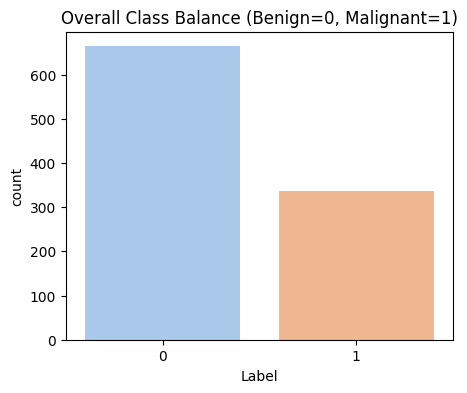

In [61]:
# Bar chart
plt.figure(figsize=(5,4))
sns.countplot(x="Label", data=df_cls, palette="pastel")
plt.title("Overall Class Balance (Benign=0, Malignant=1)")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


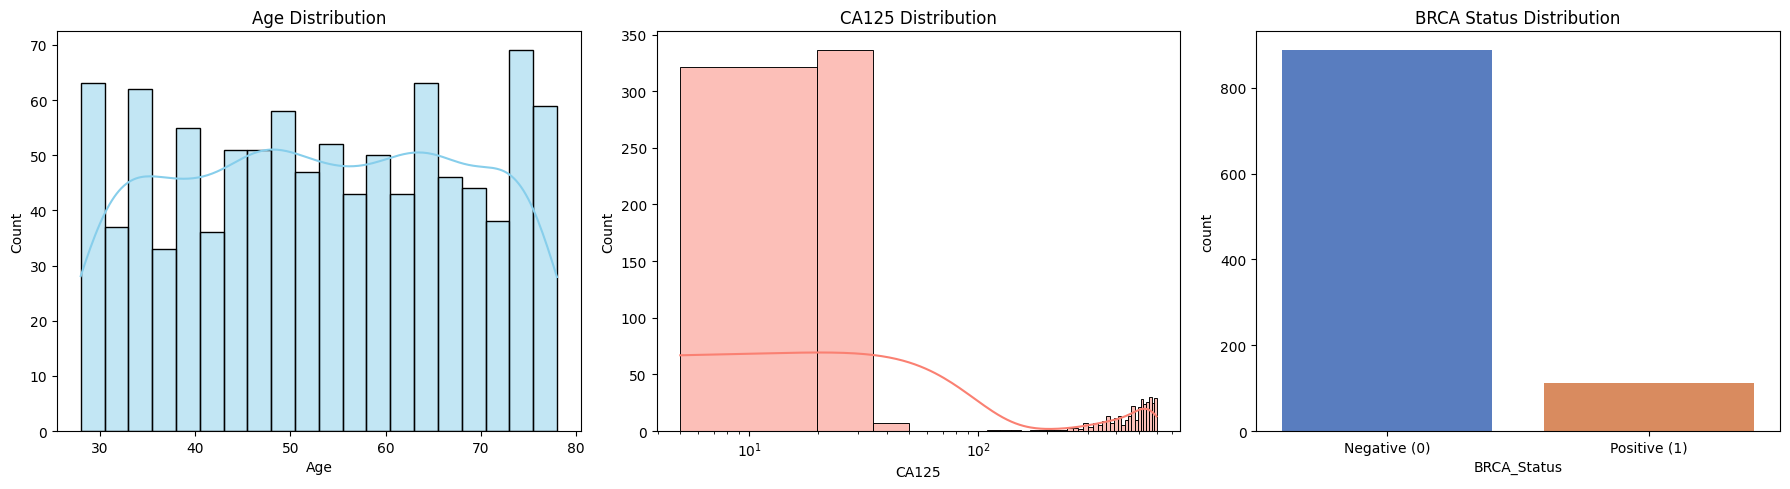

In [62]:
# 2. Biomarker distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age
sns.histplot(df_cls["Age"], bins=20, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Age Distribution")

# CA125 (log scale, since skewed)
sns.histplot(df_cls["CA125"], bins=40, kde=True, ax=axes[1], color="salmon")
axes[1].set_title("CA125 Distribution")
axes[1].set_xscale("log")

# BRCA
sns.countplot(x="BRCA_Status", data=df_cls, ax=axes[2], palette="muted")
axes[2].set_title("BRCA Status Distribution")
axes[2].set_xticklabels(["Negative (0)", "Positive (1)"])

plt.tight_layout()
plt.show()

# 4. Data Split

In [63]:
# Perform 70/15/15 split
train_df, temp_df = train_test_split(
    df_cls, 
    test_size=0.30, 
    stratify=df_cls["Label"],  # keep class balance
    random_state=42
)

# Second split: Validation (15%) + Test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  
    stratify=temp_df["Label"],
    random_state=42
)

In [64]:
train_df.to_csv("/kaggle/working/train_split.csv", index=False)
val_df.to_csv("/kaggle/working/val_split.csv", index=False)
test_df.to_csv("/kaggle/working/test_split.csv", index=False)

In [65]:
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print("Class distribution in Train:\n", train_df["Label"].value_counts(normalize=True))

Train: 700, Val: 150, Test: 150
Class distribution in Train:
 Label
0    0.664286
1    0.335714
Name: proportion, dtype: float64
